# A Walkthrough of the Data Science Pipeline : Going from Data to Insight
  
By Zack Sating

Hello! This is a Jupyter Notebook that will walk you through the Data Science Pipeline, which is the entire process of taking data and turning it into knowledge that we can act on. This tutorial will take you through the 5 phases (or stages) of the Data Science Pipeline:
   1. Data Collection
   2. Data Processing and Cleaning
   3. Exploratory Data Analysis
   4. Hypothesis Testing and/or Machine Learning
   5. Gaining Insight (into the data or problem at hand)
  
In this notebook, we'll be looking at Twitch streamer data for the past 6 months, with the goal of being able to predict which streamers will gain a lot of traction over the next 3 months.

Why would we want to be able to predict which streamers will gain a lot of traction in, say, 3 months? Well, streaming as an industry has boomed during the pandemic, with the average number of concurrent viewers on Twitch [almost doubling within a month](https://twitchtracker.com/statistics) since the pandemic began in March 2020, and has kept growing since. There are also millions of dollars being invested into the space, whether it be for eSports teams or in sponsorships.  
  
More specifically, suppose we're a company that's looking to sponsor a streamer. If we can identify streamers who, by our models, will likely grow a lot in, say, 3 months, we'd probably want to sponsor them before that happens. Why? Well, streaming as a job can produce some of the most volatile income out there, and as a company we can provide streamers with a steady source of income as long as they show our product. The idea is that if that streamer increases their watch time at an increasing rate, our product will be shown more often to more people at a constant cost to us.  
  
Why 3 months? Well, Twitch is a growing landscape with changing ways to grow as a streamer, and a 3-month timeframe seems long enough to capture the consistency needed to grow, and short enough to capture the most recent trends. Plus, as a company, we'd want to secure semi-longterm deals to have consistent advertising on our end.

# Phase I : Data Collection

To get started, we'll import some libraries that are useful in Data Science that we'll especially need in this tutorial.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

For our task, we need to get quality streamer data from somewhere, and the [SullyGnome database](https://sullygnome.com) has different metrics for thousands of streamers. We'll get data for the top 1000 streamers (ranked by watch time) in the past 6 months. To do this, I went [here](https://sullygnome.com/channels/180/watched) and clicked the 'CSV' button at the top right of the chart to download the .csv file for the top 100 streamers, then did that for the next 9 pages and renamed them then put them all into a local folder called 'last-6-months'. The code below will load those .csv files into a new Pandas DataFrame called last6.

In [2]:
last_6 = pd.DataFrame()

for i in range(10):
    last_6 = last_6.append(pd.read_csv('last-6-months/top1000-'+str(i+1)+'.csv'))
    
last_6.drop(['Unnamed: 0','Unnamed: 1', 'Unnamed: 13', 'Peak viewers'], axis=1, inplace=True)
# indices are 0, 1, ...99, 0, 1, ...99, 0 etc. so going to reset to 0-999
last_6.reset_index(drop=True, inplace=True)
last_6.head()

,Channel,Watch time,Stream time,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,xQcOW,9240022260,114135,80956,5992454,-1473605,125380501,True,False,English
1,Gaules,5374612920,255480,21037,2844537,492355,86137052,True,True,Portuguese
2,summit1g,3396641910,104250,32581,5944969,176960,44282467,True,False,English
3,RanbooLive,2917418670,35625,81892,3298896,2369456,42436441,True,False,English
4,NICKMERCS,2858001120,55800,51218,5878122,927375,38649647,True,False,English


We'll do that again, this time for the last 3 months. It's done in the same way I got the 6-month data, starting from [this part](https://sullygnome.com/channels/90/watched) of the website instead.

In [3]:
new_3 = pd.DataFrame()

for i in range(10):
    new_3 = new_3.append(pd.read_csv('last-3-months/top1000-'+str(i+1)+'.csv'))
    
new_3.drop(['Unnamed: 0','Unnamed: 1', 'Unnamed: 13', 'Peak viewers'], axis=1, inplace=True)
# indices are 0, 1, ...99, 0, 1, ...99, 0 etc. so going to reset to 0-999
new_3.reset_index(drop=True, inplace=True)
new_3.head()

,Channel,Watch time,Stream time,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,xQcOW,4779966705,54975,86948,5992698,482576,61240805,True,False,English
1,Gaules,2697413805,128010,21071,2844544,197353,41531878,True,True,Portuguese
2,auronplay,1616324835,15735,102721,9108620,897051,29312107,True,False,Spanish
3,ibai,1579601205,22620,69832,6821871,1055141,46818124,True,False,Spanish
4,dota2mc_ru,1557107940,60000,25951,650926,95028,47050800,True,False,Russian


# Phase II : Data Processing and Cleaning

If you skimmed over the 6-month table,`last_6`, you might not've noticed anything, but if you look at xQcOW's `Followers gained`, you'll notice that it's almost negative 1.5 million!! How could he have lost a net 20% of his followerbase in the past 6 months? Well, a quick Google search shows that [Twitch deleted millions of bot accounts back in April](https://www.pcmag.com/news/twitch-discovers-over-75m-bot-accounts-inflating-streamer-stats), giving us massively corrupted data for the `Followers gained` variable. Before we do anything, let's look at that data a bit first - below is code that shows some streamers that had a net loss of followers:

In [4]:
negative6 = last_6[last_6['Followers gained'] < 0]
negative3 = new_3[new_3['Followers gained'] < 0]
print('Number of channels with a net loss of followers:\n')
print('In the 6-month table: '+str(len(negative6))+'\nIn the 3-month table: '+str(len(negative3)))

count = 0
for row in negative3.itertuples():
    count += 1 if row.Channel in list(negative6['Channel']) else 0
print('Number of channels that overlap in both tables: '+str(count))

negative6.head()

Number of channels with a net loss of followers:

In the 6-month table: 43
In the 3-month table: 33
Number of channels that overlap in both tables: 22


,Channel,Watch time,Stream time,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,xQcOW,9240022260,114135,80956,5992454,-1473605,125380501,True,False,English
29,sodapoppin,1541602320,75060,20538,3064772,-2852447,22551379,True,True,English
86,Nmplol,733278990,37290,19664,858193,-2132851,12815011,True,False,English
192,Myth,412255095,55395,7442,7276752,-10676,18167168,True,False,English
287,BarbarousKing,301347675,100980,2984,165397,-3090,2769409,True,True,English


How we account for this faulty data is a decision that I as the Data Scientist have to make. After scouring the [Twitch API](https://dev.twitch.tv/docs/api/reference) for calls that I could make, I didn't find any way to retrieve information on non-bot followers. The `Followers gain` and `Views gained` variables are tracked by scraping sites like the site that I got the data from, so Twitch is useless in this case.  
  
My belief is that our data will always have bot inflation as a part of it - along with many social sites on the internet as well - it's just a fact of life. There's no easy or even reasonable way to get the exact number of followers-wiped-per-channel in a few lines of code. I could try to get some median ratio between the 3-month and 6-month `Followers gained` values to try to fill in the negative values for channels in the 6-month table, but a majority of the negative `Followers gained` channels are in both tables, making an estimate useless for them. There's no other method that I can think of to salvage this data, or represent it in an accurate way, so I'm going to remove it (in the code below). After all, those channels represent only about 5% of the entire dataset, so we're preserving a grand majority of the data. Plus, the most we can really hope to do is get rid of the most skewed channels since it'd be incredibly difficult to accurately know how many bots were removed from each channel - the quickest indicator is channels with negative `Followers gained` figures.
  
The question still remains, though, of the bot-inflation for all other channels. Again, since there's no way to know how many bot accounts were deleted from each channel, or even which channels had bot accounts following them, I can't get any metric of mean or median of `Followers gained` for channels with no bot followers, which I'd apply to the other channels' `Followers gained` numbers. So, I'm not going to change anything since the numbers that we have for `Followers gained` is the best we can get without doing a massive amount of webscraping.

To be able to do any analysis, we want our 3-month table to have the same streamers by `Channel` as the data in the 6-month table, so we'll get rid of any rows where both tables don't have the same streamer. We'll also drop all of the channels that have negative Followers gain figures in them in this step. This is the bulk of the Data Cleaning phase.

In [5]:
# getting rid of rows with negative 'Followers gained' figures
new_3 = new_3[new_3['Followers gained'] > 0]
last_6 = last_6[last_6['Followers gained'] > 0]

# get rid of channels that just popped up in the last 3 months
for i, row in enumerate(new_3.itertuples()):
    if row.Channel not in list(last_6['Channel']):
        new_3.drop(index=row.Index, axis=0, inplace=True)

# get rid of channels that fell off the top 1000 in last the 3 months
for i, row in enumerate(last_6.itertuples()):
    if row.Channel not in list(new_3['Channel']):
        last_6.drop(index=row.Index, axis=0, inplace=True)

# best practice to reindex our tables after removing rows
new_3.reset_index(drop=True, inplace=True)
last_6.reset_index(drop=True, inplace=True)

# make sure both both have the same 
print('Length of new_3: '+str(len(new_3)))
print('Length of last_6: '+str(len(last_6)))

Length of new_3: 833
Length of last_6: 833


Let's just confirm that our code got rid of all of the rows that we didn't want:

In [6]:
lens = len(last_6[last_6['Followers gained'] < 0 ]), len(new_3[new_3['Followers gained'] < 0 ])
print('Number of rows with negative \'Followers gained\' figures in each table: '+str(lens))

count = 0
for row in last_6.itertuples():
    count += 1 if row.Channel in list(new_3['Channel']) else 0
    
print('Number of rows that overlap in both tables: '+str(count))

Number of rows with negative 'Followers gained' figures in each table: (0, 0)
Number of rows that overlap in both tables: 833


Awesome, our tables now have the same streamers in them.  
  
Now, to even train our model, we'll create a table called `old_3` with values that amount to `last_6` - `new_3`, which will represent the numbers of each streamer for the 3 months before the last 3 months. The idea behind creating this table is so that we can compare how streamers did over a period of 3 months to how they did over the 3 months that followed to train our model. The `old_3` table will essentialy represent the data that a hypothetical company would use to run through their prediction algorithm to see if any streamer looks like they could grow a lot. The graphic below might give you a better idea of where our tables lie on our current timeline.

![timeline](timeline3.png)

Below is code to create our `old_3` table, but first we'll reorder our rows in `new_3` to match that of `last_6` so that each streamer is at the same index in both tables. This will make computation easier.

In [7]:
# get list of indices
indices = []
for row in last_6.itertuples():
    indices.append( int(new_3[new_3['Channel'] == row.Channel].index[0] ))
    
# re-index aka sort new_3 so that it's `Channel`'s are in the same indices
new_3 = new_3.reindex(indices)
new_3.reset_index(drop=True, inplace=True)

print('Number of rows with overlapping channels: '+str(len(new_3[new_3['Channel']==last_6['Channel']])))

Number of rows with overlapping channels: 833


Now that both tables have matching `Channel` columns, we can create our `old_3` table which again is the difference between `last_6` and `new_3` for variables that apply to only a certain timeframe (like `Watch time`, `Followers gained`, etc). For `Followers`, which only applies to the point in time that it's collected, I'm going to subract `new_3`'s `Followers gained` to get what each streamer's follower count was 3 months ago. For `Average viewers`, we can easily calculate it from `old_3`'s (`Watch time`/`Stream time`). We won't touch `Partnered`, `Mature`, or `Language` since these tend to be constant over our 6-month timeframe and there's no way (that I know of) for me to figure out what they were 3 months ago.

In [8]:
old_3 = last_6.copy(deep=True)
old_3['Watch time'] = last_6['Watch time'] - new_3['Watch time']
old_3['Stream time'] = last_6['Stream time'] - new_3['Stream time']
old_3['Average viewers'] = np.array(old_3['Watch time'] / old_3['Stream time']).astype(int)
old_3['Followers'] -= new_3['Followers gained']
old_3['Followers gained'] -= new_3['Followers gained']
old_3['Views gained'] -= new_3['Views gained']
old_3.head()

,Channel,Watch time,Stream time,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,Gaules,2677199115,127470,21002,2647184,295002,44605174,True,True,Portuguese
1,summit1g,1980332340,51045,38795,5888225,120216,25662905,True,False,English
2,RanbooLive,1572890640,21105,74526,2440459,1511019,25184090,True,False,English
3,NICKMERCS,1510919115,30345,49791,5499591,548844,21263809,True,False,English
4,auronplay,1203504900,12720,94615,8211569,1153449,27237004,True,False,Spanish


It turns out there are a few channels for actual games that didn't stream in the 3 months before the most recent 3 months (vice versa for 'Warframe'), but amassed so much viewership that they ended up in the top 1000 streamers for the past 6 months. As shown below, this gives us a 0 `Watch time` for our `old_3` data which creates a some wonky numbers. We don't want these in our dataset either way since any company would already be in contact with a game studio if they wanted to sponsor them.

In [9]:
old_3[old_3['Average viewers'] < 0]

,Channel,Watch time,Stream time,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
123,Flashpoint,0,0,-9223372036854775808,231033,0,0,True,False,English
289,BeyondTheSummit2,0,0,-9223372036854775808,175528,0,0,True,False,English
333,Robleis,0,0,-9223372036854775808,1009326,0,0,True,False,Spanish
438,E3,0,0,-9223372036854775808,57066,0,0,True,True,English
771,Warframe,-40172280,3135,-12814,1350629,-121481,697297,True,False,English


The code below will get rid of all rows with any negative values anywhere in our data:

In [10]:
indices = list(old_3[old_3['Average viewers'] < 0].index)
old_3.drop(index=indices, inplace=True)

# drop them from new_3 as well
new_3.drop(index=indices, inplace=True)

# re-index both
old_3.reset_index(drop=True, inplace=True)
new_3.reset_index(drop=True, inplace=True)

print('Lengths of old_3 and new_3: '+str(len(old_3)) +', '+str(len(new_3)))

Lengths of old_3 and new_3: 828, 828


Now, not all of the bot-wiping occurred at once, it happened over the span of a few weeks in April, which affects both of our 3-month and 6-month tables. So when we subtracted `new_3`'s `Followers gained` from `last_6`'s `Followers gained`, `old_3` ended up with some negative `Followers gained` because the bot-deletion happened during `old_3`'s 3-month timespan for some channels.

In [11]:
print('Number of negative \'Followers gained\' in old_3: '+str(len(old_3[old_3['Followers gained'] < 0])))
old_3[old_3['Followers gained'] < 0].head()

Number of negative 'Followers gained' in old_3: 15


,Channel,Watch time,Stream time,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
58,Riot Games (riotgames),52153725,26205,1990,4965345,-69011,3491885,True,False,English
80,GamesDoneQuick,52701705,22680,2323,1803317,-17156,1639267,True,False,English
94,WePlayDota,395565,6435,61,212429,-6133,51979,True,False,English
180,AdmiralBulldog,199197540,34965,5697,738424,-1636,3499849,True,True,English
324,Shlorox,98011995,22320,4391,362633,-2599,3253096,True,False,German


In the same line of reasoning as when I removed the rows with negative `Followers gained` figures, I'm going to do the same here, as these channels are now the channels that experienced the bot-deletion before our recent 3-month timeframe of `new_3`. As with the first time I did this, I'll sync `old_3` and `new_3`'s indices so that computation is easier later.

In [12]:
# drop the negative 'Followers gained' from old_3
old_3 = old_3[old_3['Followers gained'] > 0]

# get rid of channels that just popped up in the last 3 months
for i, row in enumerate(new_3.itertuples()):
    if row.Channel not in list(old_3['Channel']):
        new_3.drop(index=row.Index, axis=0, inplace=True)

# best practice to reindex our tables after removing rows
new_3.reset_index(drop=True, inplace=True)
old_3.reset_index(drop=True, inplace=True)

# make sure both both have the same 
print('Length of new_3: '+str(len(new_3)))
print('Length of old_3: '+str(len(old_3)))

print('Number of rows with overlapping channels: '+str(len(new_3[new_3['Channel']==old_3['Channel']])))

Length of new_3: 813
Length of old_3: 813
Number of rows with overlapping channels: 813


We have finally gotten our data to a point where it's about as good as it can get. We discovered that Twitch had done a massive bot-wipe which horribly affected our `Followers gained` data - a figure that's important to us since we believe it's a big indicator of channel growth, which is what we want to predict.  
  
We've only sacrificed 19% of our total data, and in return we got:
- Datasets without the massive outliers of channels that had the tons of bot followers
- Datasets without anomalies of channels that only streamed in one of the 3-month periods, which is no use since they're not representative of the channels that we'd want to track.
- An overall more representative pool of data that we'd find any day from the [tracker website](https://sullygnome.com/channels/watched) we used.
  
Sidenote: none of this particular data cleaning would be necessary had Twitch not discovered/wiped the bots from the site, or if bots didn't exist in the first place.

We now have data that we are satisfied with, so we are finished with the Data Preproccessing/Cleaning phase, and can now analyze it.

# Phase III : Exploratory Data Analysis

Now we can begin exploring our data and begin to look at any relationships in the data that we might be interested in.  
  
Suppose as a sponsor we want to predict streamers that, in the next 3 months, will increase their `Watch time` and `Followers gained` by 50% in comparison to the past 3 months (quarter-over-quarter). The reasoning behind this is that we want to see our streamer not only increase the exposure of our product through increased `Watch time`, but we want our product being shown to an increasing amount of people, as well, through an increasing `Followers gained`. Here are the numbers of that.

In [13]:
important = new_3[old_3['Followers gained'] * 1.5 <= new_3['Followers gained']]
print('Streamers with 50% more \'Watch time\' over the next 3 months: '+str(len(important)))
important2 = new_3[old_3['Watch time'] * 1.5 <= new_3['Watch time']]
print('Streamers with 50% more \'Followers gained\' over the next 3 months: '+str(len(important2)))

count = 0
for row in important.itertuples():
    count += 1 if row.Channel in list(important2['Channel']) else 0
print('Streamers with both: '+str(count))

Streamers with 50% more 'Watch time' over the next 3 months: 153
Streamers with 50% more 'Followers gained' over the next 3 months: 146
Streamers with both: 83


Streamers with both credentials account for about 10% of our total data pool, which seems reasonable, as the purpose of creating a prediction algorithm is to narrow down our potential candidates to get the best of the best so we don't have to sift through hundreds of streamers manually.  
  
To get an idea of what type of model we want to use, let's look at how our key variables (`Followers gained` and `Watch time`) interact with each other. We'll start by looking at the % increase in `Followers gained` vs. the % increase in `Watch time`.

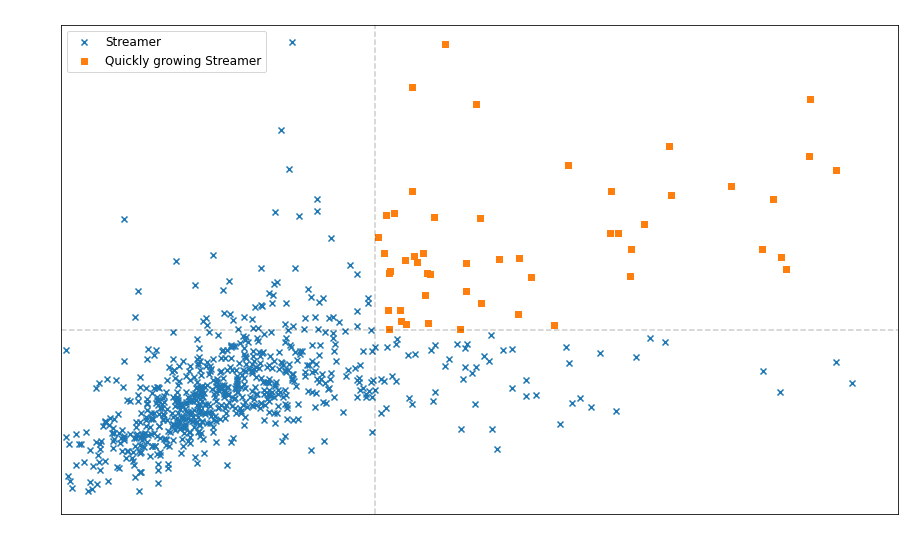

In [34]:
# the next few lines get us the channels that we've defined as 'growing channels' and formats them to be usable for us
# target_follow = want
# target_watch = want2 (change want(2) to these two)
target_follow = new_3[old_3['Followers gained'] * 1.5 <= new_3['Followers gained']].copy(deep=True)
target_watch = new_3[old_3['Watch time'] * 1.5 <= new_3['Watch time']]

for row in target_follow.itertuples():
    if row.Channel not in list(target_watch['Channel']):
        target_follow.drop(index=row.Index, inplace=True)
want_old = old_3.take(indices=list(target_follow.index))

# make this a function so that we can call it later
def plot_important(upper_bound : int, add_extra = -1, scale='linear'):
    fig, ax = plt.subplots(1,1)

    x = 'Followers gained'
    y = 'Watch time'

    # plotting data, I make sure to make each point a percentage by multiplying by 100 (ex. 100 * (10-8)/8 = 25%)
    ax.scatter(list( 100*(new_3[x]-old_3[x]) / old_3[x]), list( 100* (new_3[y]-old_3[y]) / old_3[y] ),
               label='Streamer', marker='x')
    ax.scatter(list( 100*(target_follow[x]-want_old[x]) / want_old[x]), list( 100*(target_follow[y]-want_old[y]) / want_old[y] ), 
               label='Quickly growing Streamer', marker='s')

    # adding the asymptotic lines at the 50% marker for each axis
    ax.plot([-100, upper_bound], [50,50], color='black', linestyle='dashed', alpha=0.2)
    ax.plot([50, 50], [-100,upper_bound], color='black', linestyle='dashed', alpha=0.2)
    
    if add_extra != -1:
        ax.plot([add_extra, add_extra], [-upper_bound, upper_bound], color='purple', linestyle='dashed', alpha=0.3)

    # beautifying our chart :)
    LABEL_COLOR = 'white'
    ax.legend(loc='upper left', prop={'size':12})
    ax.set_title('% Change in (Followers Gained vs. Watch Time) for Twitch Streamers Between 2 Consecutive 3-Month Periods',
                 size=15, color=LABEL_COLOR)
    ax.set_xscale(scale)
    ax.set_yscale(scale)
    lower_bound = 50 if scale == 'log' else -100    
    ax.set_xbound(lower_bound, upper_bound)
    ax.set_ybound(lower_bound, upper_bound)
    ax.set_xlabel('Percent Change in Followers Gained', color=LABEL_COLOR, size=15)
    ax.set_ylabel('Percent Change in Watch Time', color=LABEL_COLOR, size=15)
    ax.tick_params(color=LABEL_COLOR, labelcolor=LABEL_COLOR, which='both')
    fig.set_figwidth(15)
    fig.set_figheight(9)
    
plot_important(300)

In the chart, we see the orange (square) markers indicating streamers that satisfied both of our conditions to be a growing channel (by our standards): their `Followers gained` numbers increased by 50% and their `Watch time` increased by 50% from the previous 3 months in `old_3` to the current 3 months in `new_3` (again, quarter-over-quarter). I've added some asymptotic lines at the 50% marks on each axis to show these boundaries.  
  
There seems to be quite a few points that exceed the 200% threshold of 'Percent Change in Followers Gained', meaning that the rate at which a streamer gains followers more than tripled over 3 months. This isn't unreasonabale, as I've seen it happen with multiple streamers. But, if I were to extend the graph even more, we'd see about a dozen points with over 500% increases in `Followers gained`. It happens to be that most of them have comparable increases in `Watch time` as well, suggesting that that gain in followers is natural, while only about a dozen seem to have an insane increase in `Followers gained` with little to show for increase in `Watch time` (see plot below). I'd bet that's because of the massive bot-deletion, and those channels weren't caught by my data cleaning methods from before. Only having maybe a dozen points that seem to be unnatural is certainly a lot better than the 100+ I'd assume we would have before our data cleaning, so I'm satisfied with the quality of data we have.

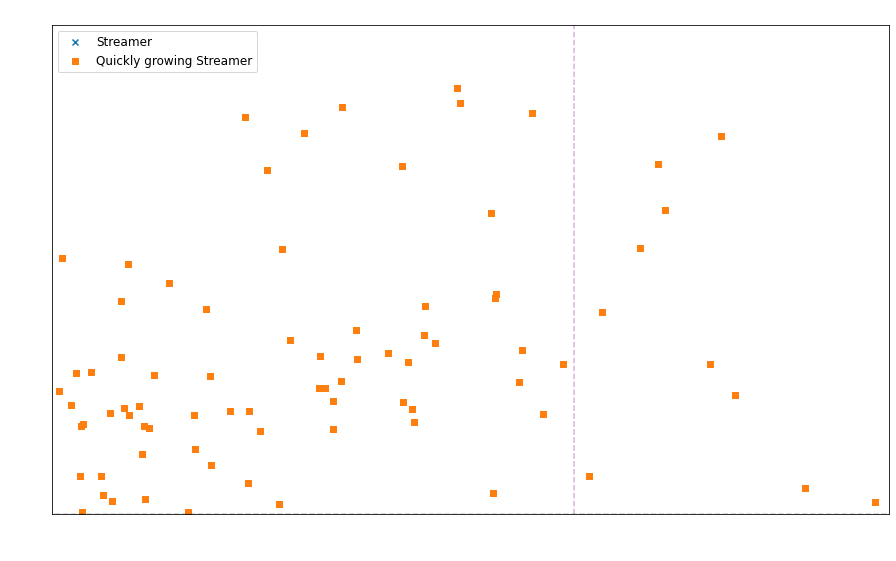

In [35]:
plot_important(2000, add_extra=500, scale='log')

On our x & y ranges 50-2000, we can see above that there are only a few points that have a massive increase in `Followers gained` with little to no increase in `Watch time`, as shown by the purple partition line at x=500 that I added. If we were really particular about having the best data, we could write another 50 lines of code to take out some of the point

Let's also take a look at some other metrics to see what else we know about our quick-growing streamers.

We'll start with ...

(keep?) There isn't much more to explore in our data, since we have the goal of making a machine learning algorithm. The main reason we plotted those points was to see what type of algorithm we would need for our prediction model. A non-linear SVM seems apt for the job because of the cluster of data points we have. A non-linear SVM (Support Vector Machine) is an algorithm that will classify (or "split") datapoints in a space of data based on a function - you can learn more [here](https://www.aitude.com/svm-difference-between-linear-and-non-linear-models/). We'll continue on to the Hypothesis Testing (more so the Machine Learning phase in this tutorial) phase of the Data Science pipeline now that we have a plan and have analyzed the data.

# Phase IV : Machine Learning and Hypothesis Testing

For the Machine Learning and Hypothesis Testing phase, we're going to train and test two different models - the Non-Linear SVM, as well as a Random Forest - and compare their results. This will be supervised machine learning since we're giving the models the correct answers and allowing them to adjust accordingly. We'll compare the two models by doing a 10-fold Cross Validated paired T-test, which essentially compares two models (our SVM and the Random Forest) and will determine if they are statistically different, based on some significance (you can learn more about K-fold CV [here](https://machinelearningmastery.com/k-fold-cross-validation/) and paired T-tests [here](https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/)). We'll discuss the null and alternate hypothesis for the paired T-test when we get to it. First, we'll make our models and see how well they perform.

We'll use the sklearn (scikit-learn) models RandomForestClassifier and svm.NuSVC for our model creation:

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import sklearn.model_selection as ms

Firstly, we're going to have to give our models a way to check their predictions against the correct answers, so we'll create a list of correct answers called `targets`, and we'll assign them to 1 of 2 classes: 'class_0' or 'class_1', where 'class_1' is what we'll name the channels that satisfy our conditions of being a "growing" channel, and 'class_0' isn't.

In [17]:
targets = [0]*len(old_3)
for i, target in enumerate(targets):
    targets[i] = 'class_1' if i in list(want.index) else 'class_0'

print('Last 5 for example: '+str(targets[-5:]))

Last 5 for example: ['class_0', 'class_0', 'class_1', 'class_0', 'class_1']


Since we have language as a variable (and it's a string) we need to somehow encode that numerically. We can do this with 'dummy variables', which is when we have nominal (or named) data, not numeric data, and encode each class as their own variable as True/False. This is so that our algorithms don't try to rank the languages numerically (1, 2, ...) and instead interpret them as a T/F value.  
  
But why not try to generalize by asking if the `Language` is, say, English or not, since English is by far the most popular language on Twitch? What I'm going to do instead is boil `Language` down to 5 categories: 'English', 'Korean', 'Spanish or Portuguese (Sp/Pr)', 'French / German (Fr/Gr)', and 'other'. We can see below that each of these languages makes up at least 5% of our total pool of data, so I personally want to account for them somehow. I'm choosing to group Spanish + Portuguese and French + German because each pair's speakers live in similar regions of the world and have similar socioeconomic statuses (Latin America, Western Europe, and S. Korea), and thus economic prosperity for those regions might make streamers of those languages grow because of increased access to internet. I'm going to encode this by having 4 dummy variables, 1 for each language / pair of languages that I named, and the default case where none are True and the language is 'other'.

Below we see the number of streamers for all languages, with the 6 that I mentioned making up at least 5% (~40/800) of the total pool.

In [18]:
print('Number of streamers for each language:\n')
for lang in old_3['Language'].unique():
    channels = old_3[old_3['Language'] == lang]
    print(lang+' : '+str(len(channels)))

Number of streamers for each language:

Portuguese : 66
English : 368
Spanish : 85
Russian : 31
German : 43
Korean : 55
Japanese : 14
French : 55
Turkish : 26
Italian : 21
Polish : 14
Chinese : 24
Thai : 4
Czech : 3
Slovak : 1
Arabic : 2
Greek : 1


Below, we encode the language groups that I outlined above:

In [19]:
langs_keep = ['English', 'Sp/Pr', 'Korean', 'Fr/Gr']

langs_split = pd.get_dummies(old_3.Language)
langs_split['Sp/Pr'] = langs_split['Spanish'] + langs_split['Portuguese']
langs_split['Fr/Gr'] = langs_split['French'] + langs_split['German']

for lang in list(langs_split.columns):
    if lang not in langs_keep:
        langs_split.drop(columns=lang, inplace=True)

langs_split.head()

,English,Korean,Sp/Pr,Fr/Gr
0,0,0,1,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,0,1,0


Now we can add those dummy variables to our training set `training_set` and drop the `Channel` and `Language` variables since they're nominal and no longer have any effect on the classification. Notice that `training_set` uses the data from `old_3`, since we needed to use `new_3`'s data to get the 'answers' to our supervised model.

In [20]:
training_set = pd.concat([old_3, langs_split], axis=1)
training_set.drop(columns=['Channel', 'Language'], inplace=True)
training_set.head()

,Watch time,Stream time,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,English,Korean,Sp/Pr,Fr/Gr
0,2677199115,127470,21002,2647184,295002,44605174,True,True,0,0,1,0
1,1980332340,51045,38795,5888225,120216,25662905,True,False,1,0,0,0
2,1572890640,21105,74526,2440459,1511019,25184090,True,False,1,0,0,0
3,1510919115,30345,49791,5499591,548844,21263809,True,False,1,0,0,0
4,1203504900,12720,94615,8211569,1153449,27237004,True,False,0,0,1,0


This code below will split our data into training and test data that we'll use for our ML algorithms.

In [21]:
X_train, X_test, y_train, y_test = ms.train_test_split(training_set, targets, train_size=0.7)
print('Number of training examples: '+str(len(X_train)) +'\nNumber of test examples: '+ str(len(X_test)))

Number of training examples: 569
Number of test examples: 244


Now that our data is properly formatted, we can begin doing our machine learning.

### Hyperparameters for Random Forest:
We'll use bootstrapping by setting `bootstrap=True`, which pulls a random subset of rows from the training set to train each decision tree on. To control that number, we can adjust `max_samples`, which I've set to 200 (out of 569). These combined will hopefully decrease the bias of outliers by giving different samples to each of the 100 trees we're putting in our forest. To try to prevent overfitting, I've also specified `max_depth` to be 5, which means that after a maximum of 5 decisions each tree will have to make a best guess as to which class the example is. The makes each tree more generalized so that it hopefully can't overfit to a specific pattern (like a few highly bot-deleted channels or a few channels with a less-spoken language) that we didn't account for. To hopefully keep each tree (and thus the entire forest) more general, I've set `min_samples_leaf` to 3, which means that for a tree to create a node, there needs to be at least 3 samples at that node.
  
We can see in the output below that we have about a 92% mean score, with a standard deviation of about 3%, and the list of the 10 scores show a fairly tight range in accurancy.

In [22]:
rfc = RandomForestClassifier(bootstrap=True, min_samples_leaf=3, max_depth=5, max_samples=200)
rfc.fit(X_train, y_train)

scores = ms.cross_val_score(rfc, training_set, targets, cv=10)

print('\nMean CV score of: %.2f' % (scores.mean()*100) + '%% with a standard deviation of: %.2f%%' % (scores.std()*100))
print('\nScores : '+str(scores))


Mean CV score of: 91.52% with a standard deviation of: 4.02%

Scores : [0.8902439  0.90243902 0.8902439  0.91358025 0.88888889 0.90123457
 0.96296296 0.96296296 0.98765432 0.85185185]


### Hyperparameters for SVM:
Our non-linear SVM will use a `nu` parameter, which can be interpreted as the maximum percentage of misclassifications we want to allow ([here](https://stackoverflow.com/questions/11230955/what-is-the-meaning-of-the-nu-parameter-in-scikit-learns-svm-class) is an explanation). We're also adjusting the tolerance `tol` of the model, which determines at which point our model should stop searching for a minimum error ([here](https://stats.stackexchange.com/questions/255375/what-exactly-is-tol-tolerance-used-as-stopping-criteria-in-sklearn-models) is another explanation). After a bit of fine-tuning, I found these values for these hyperparamters to work well. I found a [radial basis function](https://deepai.org/machine-learning-glossary-and-terms/radial-basis-function) to work the best as opposed to a polynomial or linear function as well.  
  
We can see in the output below that we have about a 85% mean score, with a standard deviation of about 15%, and the list of the 10 scores show a fairly tight range in accurancy except for 1 outlier at the start. My guess is that there's some factor that I'm unknowledgeable of that is doing this. Nonetheless, this is about as good as I could get the model for these parameters.

In [23]:
svm_model = svm.NuSVC(nu=0.18, kernel='rbf', tol=0.0001)
# svm_model = svm.LinearSVC(max_iter=100, multi_class='crammer_singer')
svm_model.fit(X_train, y_train)

scores = ms.cross_val_score(svm_model, training_set, targets, cv=10)

print('\nMean CV score of: %.2f' % (scores.mean()*100) + '%% with a standard deviation of: %.2f%%' % (scores.std()*100))
print('\nScores : '+str(scores))


Mean CV score of: 85.78% with a standard deviation of: 15.67%

Scores : [0.3902439  0.8902439  0.8902439  0.91358025 0.88888889 0.91358025
 0.9382716  0.92592593 0.92592593 0.90123457]


I mentioned at the start of this phase that we'd use a T-test to evaluate how these two models compare to one another. A t-test will do just that, and will give us back a p-value. This p-value determines where or not we can reject the null hypothesis, and the p-value must be `p<0.05` to do so. The null hypothesis for the t-test is that both models perform roughly the same for our data, and any variance is due to statistical chance. Below I run this t-test 10 times just to be confident in our p-value.

In [24]:
# this is a nice library to do our 10-fold cross validated t-test all in one step
from mlxtend.evaluate import paired_ttest_kfold_cv

sum_p = np.array([])
# going to sum, then average the 10 p-values we get
for i in range(10):
    t, p = paired_ttest_kfold_cv(estimator1=rfc,
                                 estimator2=svm_model,
                                 X=np.array(training_set), y=np.array(targets),
                                 cv=10) # make it do 10 folds for the cross validation
    sum_p = np.append(sum_p, p)

print('Mean P-value of : %.3f\nwith a standard deviation of : %.3f' % (sum_p.mean(), sum_p.std()))

Mean P-value of : 0.069
with a standard deviation of : 0.007


Remember that the null hypothesis for a t-test is that both models being compared perform equally well on our data. To reject the null hypothesis we need to get a p-value of `p<0.05`, which gives us enough evidence to reject the null hypothesis in favor  of the alternate hypothesis, which is that the two models do not perform equally well on our data. Note that a p-value of 0.05 is generally accepted in the Data Science field, and is just a general confidence interval of where we can expect performance to lie on a distribution.  
  
In the case of our two models (Random Forest and SVM), we've gotten an average p-value of 0.069, which is not less than 0.05, so we do not have enough evidence to reject the null hypothesis (by our standards). We can thus assume that both models perform roughly equally well. This makes sense, too, if you look back the numbers we got when we tested each model individually, you'll see that our Random Forest looked better in terms of mean accuracy and standard deviation of that accuracy, but both models had roughly the same scores, except 1 of the SVM's scores was ~40% - likely because of some hyperparameter that I don't know of. Besides that outlier, their scores are roughly the same.

# Phase V : Gaining Insight into the Data

The whole point of gathering the data, cleaning it up, looking for any relationships/patterns in it, and creating models around the data was to actually use those models to make predictions about the future. So let's do that.
  
We know a few things now:
- Both models perform roughly equally well on our data
- Their mean accuracies are around 90% on our data (except for the outlier that drags down the SVM's score)

Since they perform roughly well according to our T-test, I'll pick the Random Forest Classifier model we created, `rfc`, to make some predictions on our recent data, `new_3`, since it was consistently around a 90% accuracy rate.

In [25]:
# need to make our testing data the same shape as our training data with the language variables and such
langs_keep = ['English', 'Sp/Pr', 'Korean', 'Fr/Gr']

langs_split = pd.get_dummies(new_3.Language)
langs_split['Sp/Pr'] = langs_split['Spanish'] + langs_split['Portuguese']
langs_split['Fr/Gr'] = langs_split['French'] + langs_split['German']

for lang in list(langs_split.columns):
    if lang not in langs_keep:
        langs_split.drop(columns=lang, inplace=True)

testing_set = pd.concat([new_3, langs_split], axis=1)
testing_set.drop(columns=['Channel', 'Language'], inplace=True)

# generating predictions
predictions = rfc.predict(training_set)
indices = list(np.where(predictions=='class_1'))[0]
print('Number of predictions: '+str(len(indices))+'\n'+str(indices))

Number of predictions: 33
[204 206 227 242 324 328 566 586 591 594 605 610 624 653 655 667 675 702
 705 709 728 730 734 740 741 761 776 777 783 794 796 810 812]


We see we've gotten back quite a few predictions, and we can cross-check those indices with the `new_3` table to see who these streamers are. Notice that most of these predictions are in the lower half of the top 1000 streamers, which intuitively makes sense since you're less likely to "blow up" or "grow" exponentially if you're already at the top. We'll pick a random 5 streamers that our model predicted and display their stats:

In [26]:
predicted = new_3.iloc[indices]
predicted.sample(n=5)

,Channel,Watch time,Stream time,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
810,curvyelephant,61516155,41595,1478,101172,18187,848216,True,False,English
777,Zwave69,79004745,38895,2031,253899,103003,3194648,True,False,French
667,Carola,111450645,22395,4976,354319,253036,4401615,True,False,Spanish
761,mortenroyale,77699715,25230,3079,182634,67342,3552759,True,False,German
812,Kidi,90864675,51780,1754,233675,45198,4192071,True,False,Spanish


These are a few streamers that our model thinks will grow in the next 3 months according to our definition of "growing", which was to increase `Watch time` and `Followers gained` by 50% from the past 3-month timeframe to the next 3-month timeframe. 'Carola' and 'mortenroyale' stand out to me as they have high `Followers gained` numbers in comparison with their total `Followers` figure. Maybe you'd want to sponsor those streamers as they've just made big leaps in popularity, or maybe you'd want to go with a smaller streamer with a lower `Followers gained` figure to try to catch their wave of popularity, thus paying less to sponsor them.  
  
From here, you can filter streamers by language, number of `Average viewers`, etc. as a company, then look at each streamer manually and see if you want to sponsor them.

## In sum:
  
We've successfully gone from raw data to getting real insight into what we wanted to do at the start. We now have models that can predict, fairly well, which streamers will grow over a 3-month period - at least on our data. We tried our best to clean the data and get rid of channels that had lost a lot of bot followers, as they would've skewed our models.  
  
We can go back at any time and change how we define a "growing" streamer - maybe we want to include streamers that grow their `Average viewers` by 50% quarter-over-quarter. Either way, our process of going from data to insight is essentially complete here.  
  
Sidenotes in sum: the bulk of our Data Cleaning phase was necessary because Twitch wiped millions of bot accounts, massively corrupting the `Followers gained` numbers we have. Since that was about 3 months ago, we could've just gotten data from the past 2 months and split it into 2 1-month periods, but as I mentioned at the start, I believe a 3-month timeframe best captures the consistency of streamers, as well as trends of growing streamers. Often, projects that follow this Data Science Pipeline will spend most of the work on data cleaning and preparation, because data isn't perfect, and we'll often have to do a lot of work to get it into a form we can work with, as was shown in this notebook.

This concludes the tutorial, thank you for reading!